<a href="https://colab.research.google.com/github/dcbrien/ML_Tests/blob/master/YOLO1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing YOLO v1 as a learning tool

In [1]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing

import seaborn as sns
import glob2

from matplotlib.patches import Rectangle

In [ ]:
# Download VOC challenge 2007
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

--2021-08-10 20:37:37--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================>] 430.13M  4.88MB/s    in 91s     

2021-08-10 20:39:10 (4.71 MB/s) - ‘VOCtest_06-Nov-2007.tar’ saved [451020800/451020800]



In [ ]:
# And unzip
!tar -xvf VOCtest_06-Nov-2007.tar

(97, 155)
(36, 94, 0.119140625, 0.119140625)


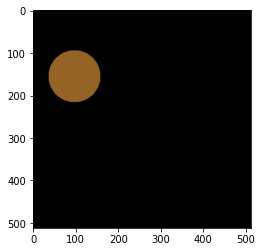

In [2]:
# The first thing we will need is a dataset.  Let's make a super simple one where we try to first identify, and second label with bounding
# boxes, simple shapes in a relatively small image set.

# As an example, here is one image with a circle, square, and triangle
IMG_SIZE = (512, 512, 3)

img = np.zeros(IMG_SIZE, np.float32)

# Circles
MIN_C_SIZE = 10
MAX_C_SIZE = 100

c_size = np.random.randint(low=MIN_C_SIZE, high=MAX_C_SIZE)

# We will bound the circle so that it is fully in the image for now - We can try to get it to recognized cropped versions later
b_irange = (np.random.randint(low=c_size, high=IMG_SIZE[0]-c_size), np.random.randint(low=c_size, high=IMG_SIZE[1]-c_size))
print(b_irange)

# For each shape we need the bounding box.  This is defined as [x, y, w, h] in the original paper.  For a circle this is simple.
bbox = (b_irange[0]-c_size, b_irange[1]-c_size, c_size/IMG_SIZE[0], c_size/IMG_SIZE[1])
print(bbox)

img2 = cv.circle(img, b_irange, c_size, (np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)), -1)

# # Rectangles - 2 points and a colour
# r_pt1 = (np.random.randint(low=c_size, high=IMG_SIZE[0]-c_size), np.random.randint(low=c_size, high=IMG_SIZE[1]-c_size))
# r_pt2 = (np.random.randint(low=c_size, high=IMG_SIZE[0]-c_size), np.random.randint(low=c_size, high=IMG_SIZE[1]-c_size))

# # For the rectangle, the bounding box is also simple
# r_min_x = np.min([r_pt1[0], r_pt2[0]])
# r_max_x = np.max([r_pt1[0], r_pt2[0]])
# r_min_y = np.min([r_pt1[1], r_pt2[1]])
# r_max_y = np.max([r_pt1[1], r_pt2[1]])

# bbox = (r_min_x, r_min_y, (r_max_x-r_min_x)/IMG_SIZE[0], (r_max_y-r_min_y)/IMG_SIZE[1])
# print(bbox)

# img2 = cv.rectangle(img2, r_pt1, r_pt2, (np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1)), -1)

# # Triangles - 3 points and a colour drawn as a polyfill

# pts = np.array([[np.random.randint(low=c_size, high=IMG_SIZE[0]-c_size), np.random.randint(low=c_size, high=IMG_SIZE[1]-c_size)],
#                 [np.random.randint(low=c_size, high=IMG_SIZE[0]-c_size), np.random.randint(low=c_size, high=IMG_SIZE[1]-c_size)],
#                 [np.random.randint(low=c_size, high=IMG_SIZE[0]-c_size), np.random.randint(low=c_size, high=IMG_SIZE[1]-c_size)]], np.int32)
# pts = pts.reshape((-1,1,2))

# # For the triangles, the bounding box is also simple
# r_min_x = np.min([pts[0][0][0], pts[1][0][0], pts[2][0][0]])
# r_max_x = np.max([pts[0][0][0], pts[1][0][0], pts[2][0][0]])
# r_min_y = np.min([pts[0][0][1], pts[1][0][1], pts[2][0][1]])
# r_max_y = np.max([pts[0][0][1], pts[1][0][1], pts[2][0][1]])

# bbox = (r_min_x, r_min_y, (r_max_x-r_min_x)/IMG_SIZE[0], (r_max_y-r_min_y)/IMG_SIZE[1])
# print(bbox)

# img2 = cv.fillPoly(img2, [pts], (0,255,255))

plt.imshow(img2)

In [3]:
# A class to either generate synthetic data or use the VOC challenge 2007 to
# generate bounding box data for classification

class yoloGenerator():
  def __init__(self, num_samp, S, B, img_size=(224, 224, 3), synth=True, batch_size=32):
    self.S = S  # Number of subdivisions of grid
    self.B = B  # Number of bounding boxes to predict per gric cell
    self.num_samp = num_samp
    self.img_size = img_size
    self.synth = synth
    self.batch_size = batch_size

    self.G_SIZE = self.img_size[0]//self.S

    if synth:
      self.C = 3

      imgs, labels = self.makeSythData()

      self.img_ls = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(imgs), tf.data.Dataset.from_tensor_slices(labels)))   

      self.img_ls_b = self.img_ls.batch(self.batch_size,drop_remainder=True)
    else:
      # TODO: Add code to convert VOC data to a tf.dataset
      # VOC has 20 classes
      self.C = 20

  # Return synethic data of circles, squares, and rectangles  
  def makeSythData(self, objs_per_img=3):
    # There are many ways to do this, but we don't need that much data so we
    # will just create it all in memory as a dataset.  If you had a lot of 
    # images you would need to stream them from disk.  Just don't make num_samp 
    # too large (keep it under 10K with a high-ram colab).
    # The array holding the raw image data
    imgs = np.zeros((self.num_samp, self.img_size[0], self.img_size[1], self.img_size[2]), np.float32)

    # The labels are a tensor of (SXSX(4+C)) where the (4+C) is x, y, w, h, 
    # class. Classes are one-hot.  It will be mostly zeros and there can only 
    # be one object per grid cell.
    labels = np.zeros((self.num_samp, S, S, 4 + self.C), np.float32)

    for s in range(self.num_samp):
      img = np.zeros(self.img_size, np.float32)

      for i in range(objs_per_img):
        img_t = np.random.randint(0, 2)

        if img_t == 0:
          self.addCircle(img, labels, s)
        elif img_t == 1:
          self.addRectangle(img, labels, s)

      imgs[s, :] = img

    return imgs, labels

  def addCircle(self, img, labels, s):
    # Constansts for circles
    MIN_C_SIZE = 20
    MAX_C_SIZE = 41
    c_size = np.random.randint(low=MIN_C_SIZE, high=MAX_C_SIZE)

    # We will bound the circle so that it is fully in the image for now - We can try to get it to recognized cropped versions later
    b_irange = (np.random.randint(low=c_size, high=self.img_size[0]-c_size), np.random.randint(low=c_size, high=self.img_size[1]-c_size))
    # For each shape we need the bounding box.  This is defined as [x, y, w, h] in the original paper.  For a circle this is simple.
    bbox = (b_irange[0]-c_size, b_irange[1]-c_size, c_size*2./self.img_size[0], c_size*2./self.img_size[1])

    #Find the grid cell of this object
    g_x = b_irange[0] // self.G_SIZE
    g_y = b_irange[1] // self.G_SIZE

    # We only draw if there is no object in that grid cell already
    if np.sum(labels[s, g_x, g_y, 4:]) == 0:
      # I bound the colours to make it more realistic.  Most circles will have similar colours, just as most objects in real images will h
      # have similar colour profiles
      img = cv.circle(img, b_irange, c_size, (np.random.uniform(0.5, 0.7), np.random.uniform(0.5, 0.7), np.random.uniform(0.5, 0.7)), -1)

      # Find the relative position
      g_xpos = (b_irange[0] % self.G_SIZE) / self.G_SIZE
      g_ypos = (b_irange[1] % self.G_SIZE) / self.G_SIZE

      # The label - First position is 1 for circles
      labels[s, g_x, g_y] = [g_xpos, g_ypos, bbox[2], bbox[3], 1, 0, 0]

  def addRectangle(self, img, labels, s):
    # Rectangles - 2 points and a colour   

    # Constansts for rectangles
    MIN_R_SIZE = 20
    MAX_R_SIZE = 41
    r_size = np.random.randint(low=MIN_R_SIZE, high=MAX_R_SIZE)

    r_pt1 = (np.random.randint(low=r_size, high=self.img_size[0]-r_size), np.random.randint(low=r_size, high=self.img_size[1]-r_size))
    r_pt2 = (np.random.randint(low=r_size, high=self.img_size[0]-r_size), np.random.randint(low=r_size, high=self.img_size[1]-r_size))

    # For the rectangle, the bounding box is also simple
    r_min_x = np.min([r_pt1[0], r_pt2[0]])
    r_max_x = np.max([r_pt1[0], r_pt2[0]])
    r_min_y = np.min([r_pt1[1], r_pt2[1]])
    r_max_y = np.max([r_pt1[1], r_pt2[1]])

    bbox = ((r_max_x-r_min_x) / 2., (r_max_y-r_min_y) / 2., (r_max_x-r_min_x)/self.img_size[0], (r_max_y-r_min_y)/self.img_size[1])

    #Find the grid cell of this object
    g_x = (bbox[0] + r_min_x) // self.G_SIZE
    g_y = (bbox[1] + r_min_y) // self.G_SIZE

    # We only draw if there is no object in that grid cell already and the area of the rectangle is reasonable (0.01 here)
    if np.sum(labels[s, int(g_x), int(g_y), 4:]) == 0 and bbox[2] * bbox[3] > 0.01:
      img = cv.rectangle(img, r_pt1, r_pt2, (np.random.uniform(0.5, 0.7), np.random.uniform(0.5, 0.7), np.random.uniform(0.5, 0.7)), -1)

      # Find the relative position
      g_xpos = ((bbox[0] + r_min_x) % self.G_SIZE) / self.G_SIZE
      g_ypos = ((bbox[1] + r_min_y) % self.G_SIZE) / self.G_SIZE

      # The label - Second position is 1 for circles
      labels[s, int(g_x), int(g_y)] = [g_xpos, g_ypos, bbox[2], bbox[3], 0, 1, 0]

  def plotImg(self, img, label):
    major_ticks = np.arange(self.G_SIZE, self.img_size[0], self.G_SIZE)

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)

    plt.imshow(img)
    plt.grid(True)

    obs = np.where(np.sum(label[:, :, 4:], axis=-1) > 0)

    for s in range(obs[0].shape[0]):
      g_x=obs[0][s]
      g_y=obs[1][s]

      s_label = label[g_x, g_y]

      obj_c = (g_x*self.G_SIZE+self.G_SIZE*s_label[0], g_y*self.G_SIZE+self.G_SIZE*s_label[1])

      plt.plot(obj_c[0], obj_c[1], 'x')

      ax.add_patch(Rectangle((obj_c[0]-(s_label[2]*self.img_size[0])/2., obj_c[1]-s_label[3]*self.img_size[1]/2.), 
                            s_label[2]*self.img_size[0], s_label[3]*self.img_size[1], color = 'c', alpha=1, fill=False))


In [7]:
NUM_SAMP = 3000
S = 7
B = 2

X_data = yoloGenerator(NUM_SAMP, S, B, img_size=(448, 448, 3), batch_size=16)

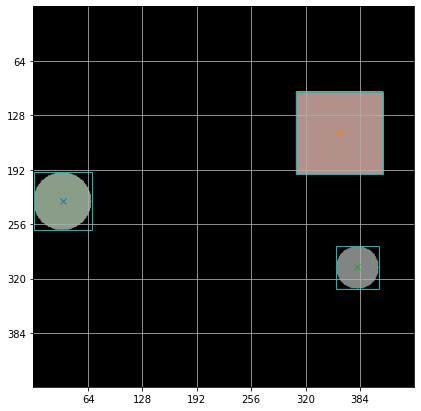

In [8]:
# Plot an example
for s_samp in X_data.img_ls_b.take(1):
  X_data.plotImg(s_samp[0][0, :, :, :], s_samp[1][0, :, :, :])

In [10]:
from tensorflow.keras.applications.resnet import ResNet101
# The model

# 1 - Divide image into S x S grid
# 2 - For each grid cell, detect an object and predict its bounding box
#      - Each grid cell predicts B bounding boxes and confidence scores
#      - Confidence = Pr(Object) * IOU{truth/pred}.  This should be 0 when no
#        Object is present and the IOU when one is present
#      - Each bounding box predicts x, y, w, h and C, where x, y is the center
#        prediction of the bounding box relative to the bounds of the grid cell
#        (percentage of grid cell size) and w, h are predicted relative to the 
#        entire image (percentages).  I think it makes the loss function 
#        simpler to have all values between 0 and 1.  It also normalizes the 
#        values so they all have equal weight in the loss function.
# 3 - Each grid cell predicts C conditional class probabilities
#   Pr(Class(i)|Object).  If the grid contains an object, it predicts a class. 
#   This is only done once per grid cell, regardless of the number of bounding 
#   boxes B.  It does seem like this could be a softmax instead, but they are 
#   just predicting independent probabilities and using MSE to calculate the 
#   loss.
#      - At test time, we can therefore multiple Pr(Class(i)|Object) * 
#        Pr(Object) * IOU{truth/pred} = Pr(Class(i)) * IOU{truth/pred}.  Which 
#        are class specific confidence sscores for each bounding box. 
#        IOU{truth/pred} are probabilities as well as they are bounded [0, 1]

# The output of the model should be a tensor of size S * S * (B * 5 + C).  This 
# 5 values per bounding box + C class probabilites all per grid cell

# The model is super simple.  Use some kind of convolution network to extract 
# the features and use a FCN top level to generate the prediction tensor.  I 
# think just a pre-trained ResNet with some extra convolution layers and a FCN 
# top layer should work reasonably well.  The last layer has no activation 
# function to allow it to predict the complete range of bounding box and 
# confidence intervals without asymptotes.

class YOLOv1(tf.keras.Model):
  def __init__(self, S, B, num_classes, img_size, rate=0.5):
    super(YOLOv1, self).__init__()

    # The output tensor - See Figure 2 of the paper and the paragraph just
    # underneath
    self.S = S
    self.B = B
    self.num_classes = num_classes

    self.rate = rate

    self.output_size = (S*S*(B*5+num_classes))

    # TODO: Data augmentation should go here, but will have to also adjust the 
    # bounding boxes in that case?  I don't think I will implement it for this 
    # little test case, but that would certainly be necessary for a robust 
    # object segmentation model

    # The hybrid model includes a partial ResNet as a prenet.  I cut it off at 
    # layer 3 and allow that last layer to still be trainable.  This scales 
    # everything down for cifar-10.
    base_model = ResNet101(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers:
      layer.trainable = True
    #for layer in base_model.layers[39:]:
    #  layer.trainable = True

    self.prenet = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.get_layer('conv2_block2_out').output)

    #self.tokenizer = tf.keras.layers.Conv2D(filters=d_model, kernel_size=1, strides=1, padding='valid')

    #self.glob_avg = tf.keras.layers.GlobalAveragePooling1D()

    # These layers will just bring us down to a 7x7 matrix from the original
    # ResNet.  We could make this more generic though.  It doesn't have to be 
    # so complicated
    self.conv1 = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='valid')
    self.conv2 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same')
    self.conv3 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same')
    self.conv4 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same') 
    self.conv5 = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same')

    # Now a FCN to allow some cross talk between features (I think it's
    # important to have this layer in here and not just continue to reduce 
    # down to output tensor.  This layer allows a higher level of complexity 
    # and capacity in the output space.)

    # We use 4096 just like the paper
    self.int_layer = tf.keras.layers.Dense(4096, activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='intlayer')

    self.d1 = tf.keras.layers.Dropout(self.rate)

    self.final_layer = tf.keras.layers.Dense(self.output_size, activation='linear', name='classes')

  def call(self, inp, training):
    x = self.prenet(inp)

    # Not the exact architecture of the paper, but we will apply some 
    # convolutions after the ResNet to be somewhat consistent
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)    
    x = self.conv5(x)

    x = tf.keras.layers.Flatten()(x)

    x = self.int_layer(x)

    x = self.d1(x)

    final_output = self.final_layer(x)

    # Reshape to the output tensor
    final_output = tf.reshape(final_output, [-1, self.S, self.S, self.B*5+self.num_classes])

    return final_output

In [11]:
# Let's test out YOLOv1 on a simple example first
dropout_rate = 0.5

yolo_model = YOLOv1(X_data.S, X_data.B, X_data.C, X_data.img_size, dropout_rate)

byte_samp = tf.random.normal((2, X_data.img_size[0], X_data.img_size[1], 3))

y_pred = yolo_model(byte_samp, True)

y_pred.shape

171450368/171446536 [==============================] - 2s 0us/step


TensorShape([2, 7, 7, 13])

In [12]:
# The loss function
# Inputs will be ypred, ytruth (a ragged tensor containing bounding boxes 
# and corresponding class value so Nx5 array, where the are N bounding boxes)

# ypred has 3D shape SxSx(B*5+C)

# lambda_coord = regularization parameter to weight coordinates heavily when an
# object is present

# lambda_noobj = regularization parameter to weight IOU predictions less when 
# no object is present so that the network doesn't immediately predict zero 
# confidence for every grid cell and promotes better training

# for every grid cell in SxS
#   Split ypred at this grid cell location into B*5 values and C values
#   If there an object in this grid
#     Compute x_truth, y_truth in relative coordinates to the grid cell bounds
#     Compute IOU for each B - This is C_truth - Computed by creating a mask 
#       for the original bounding box and a mask for each predicted B and then 
#       logically comparing them
#     for the max IOU
#       loss = lambda_coord * MSE in x
#       loss += lambda_coord * MSE in sqrt(w) + MSE in sqrt(h)
#       loss += SE in IOU
#       loss += SE in class probabilities for each class
#   else
#     loss = lambda_noobj * SE in IOU (IOU_truth is 0 when no object) - we want 
#       these all to go to zero so we can threshold them out later in the 
#       testing phase

# We can't use flow control statements in the loss function so we will need
# to be creative to vectorize this
# The target tensor will be SxSx5 for each image so we can create object and
# no object masks to create the loss function in a vectorized form and not 
# require for loops and if statements

EPS = 0.0000001

LAMBDA_COORD = 5.
LAMBDA_NOOBJ = 0.5

B = X_data.B
C = X_data.C

def my_loss_fun_YOLOv1(y_true, y_pred):
  # y_true has shape SxSx(4+C) - the 4 numbers are x, y, w, h and the C should 
  # be a probability array of the number of classes I think
  # y_pred has shape SxSx(B*5+C) - The same 4 numbers * B bounding boxes with 
  # the confidence score being the 5th here.  C is also the probability of each
  # class

  # The first thing we need is to know the IOU of each B when a cell has an
  # object

  # Tile the values in y_true so we can broadcast compute every IOU in the grid
  # at once
  y_true_all = y_true[:, :, :, :4]
  y_true_bbox = tf.tile(y_true_all, [1,1,1, B])
  y_true_bbox = tf.reshape(y_true_bbox, [-1, S, S, B, 4])

  # I really think, if the model has no activation function in the last layer,
  # that we have to exp the result to get values only between 0 and 1.  I 
  # verified this with a Google search.
  y_pred = tf.exp(y_pred)

  y_pred = tf.clip_by_value(y_pred, EPS, np.inf)

  # y_pred should match
  y_pred_all = y_pred[:, :, :, :B*5]
  y_pred_all = tf.reshape(y_pred_all, [-1, S, S, B, 5])
  y_pred_all = y_pred_all[:, :, :, :, :5]

  y_pred_bbox = y_pred_all[:, :, :, :, :4]

  # now compute IOU of every grid cell (even though we will only end up using
  # the ones where an object is present?)  The IOU of all non-object grid cells 
  # must be zero because the intersection of a bounding box with an empty set 
  # is empty.

  # first convert them all to proper bounding boxes [x1, y1, x2, y2]
  bbox1 = tf.stack([y_pred_bbox[:, :, :, :, 0] - y_pred_bbox[:, :, :, :, 2] / 2., 
          y_pred_bbox[:, :, :, :, 1] - y_pred_bbox[:, :, :, :, 3] / 2.,
          y_pred_bbox[:, :, :, :, 0] + y_pred_bbox[:, :, :, :, 2] / 2.,
          y_pred_bbox[:, :, :, :, 1] + y_pred_bbox[:, :, :, :, 3] / 2.], axis=-1)

  bbox2 = tf.stack([y_true_bbox[:, :, :, :, 0] - y_true_bbox[:, :, :, :, 2] / 2., 
          y_true_bbox[:, :, :, :, 1] - y_true_bbox[:, :, :, :, 3] / 2.,
          y_true_bbox[:, :, :, :, 0] + y_true_bbox[:, :, :, :, 2] / 2.,
          y_true_bbox[:, :, :, :, 1] + y_true_bbox[:, :, :, :, 3] / 2.], axis=-1)          

  xI1 = tf.maximum(bbox1[:, :, :, :, 0], bbox2[:, :, :, :, 0])
  yI1 = tf.maximum(bbox1[:, :, :, :, 1], bbox2[:, :, :, :, 1])
  xI2 = tf.minimum(bbox1[:, :, :, :, 2], bbox2[:, :, :, :, 2])
  yI2 = tf.minimum(bbox1[:, :, :, :, 3], bbox2[:, :, :, :, 3])

  # The intersection of the two bounding boxes.  The + 1. is because of the 
  # pixel space including both extremes
  AoI = tf.maximum(0., xI2 - xI1 + 1.) * tf.maximum(0., yI2 - yI1 + 1.)

  # Now calculate the areas of each bbox
  Abbox1 = (bbox1[:, :, :, :, 2] - bbox1[:, :, :, :, 0] + 1.) * (bbox1[:, :, :, :, 3] - bbox1[:, :, :, :, 1] + 1.)
  Abbox2 = (bbox2[:, :, :, :, 2] - bbox2[:, :, :, :, 0] + 1.) * (bbox2[:, :, :, :, 3] - bbox2[:, :, :, :, 1] + 1.)

  IoU = AoI / (Abbox1 + Abbox2 - AoI)

  # We will need the best IoU later
  best_IoU = tf.math.reduce_max(IoU, -1)

  IoU = tf.expand_dims(IoU, -1)


  # We want to know the max bounding box for each IoU - this one is responsible 
  # for prediction in that grid cell
  IoU_resp = tf.argsort(IoU, axis=-2, direction='DESCENDING')

  # This is super complicated in tensorflow, but to get the last dimension of
  # values intact, we treat the batches and grid as a batch dimensions and
  # sort on the next to last dimension.  Now the box paramaters in the last
  # dimension will be sorted by IoU value.
  y_pred_best = tf.gather_nd(y_pred_all, IoU_resp, batch_dims=3)
  y_pred_best = y_pred_best[:, :, :, 0, :]

  # y_pred_best now contains the 5 values for the highest IOU in each grid cell
  # Now we can start to compile the 5 part loss

  # We need to know which cells have objects as well.  This is true if any of 
  # C are 1
  obj_mask = tf.where(tf.reduce_sum(y_true[:, :, :, 4:], -1) > 0, 1., 0.)
  nobj_mask = 1. - obj_mask

  # the position
  loss1 = tf.pow((y_true[:, :, :, 0] - y_pred_best[:, :, :, 0]), 2) + tf.pow((y_true[:, :, :, 1] - y_pred_best[:, :, :, 1]), 2)
  #print(loss1.shape)
  loss1 = tf.reduce_sum(tf.reduce_sum(loss1 * obj_mask, -1), -1)

  # the width and height
  loss2 = tf.pow((tf.sqrt(y_true[:, :, :, 2]) - tf.sqrt(y_pred_best[:, :, :, 2])), 2) + tf.pow((tf.sqrt(y_true[:, :, :, 3]) - tf.sqrt(y_pred_best[:, :, :, 3])), 2)
  loss2 = tf.reduce_sum(tf.reduce_sum(loss2 * obj_mask, -1), -1)

  # the Confidence in objects - This isn't super clear in the paper. They say
  # that the confidence score should equal the IOU of the best prediction.  I 
  # have seen it implemented as a 1 or 0 though as well to predict the
  # existence of an object.  I think it should be compared to the true IOU 
  # though, as in the paper, as we want it to reflect real confidence, which 
  # will increase as IOU increases, and IOU will only increase if the previous
  # 2 losses converge on the real box as well.
  loss3 = tf.pow((best_IoU - y_pred_best[:, :, :, 4]),  2)
  loss3 = tf.reduce_sum(tf.reduce_sum(loss3 * obj_mask, -1), -1)
  
  # The Confidence in non-objects.  I assume this should just be 0.  There is 
  # no point in comparing to the true label because that value is 0.  We want
  # the last value of y_pred_best to be 0 basically.  The IoU of all of those 
  # scores should be zero, because there is no true box.  Because of the way 
  # IoU is calculated, if it's one pixel, we can can still get a IoU score,
  # even though it doesn't exist (i.e., when the true box is 0,0,0,0, that is 
  # assumed to be one pixel and has an area of 1, but we will just make that 
  # zero for the purposes of this loss)
  loss4 = tf.pow((y_pred_best[:, :, :, 4]), 2)
  loss4 = tf.reduce_sum(tf.reduce_sum(loss4 * nobj_mask, -1), -1)

  # The class loss.  Here we assume the true values will be tacked onto the 
  # end as y_true[:, :, :, 4:] with one-hot for the value of the object in that 
  # grid cell.  The prediction will also then be one-hot in the prediction 
  # array.  For now we only have one class (circles)
  loss5 = tf.pow((y_true[:, :, :, 4:] - y_pred[:, :, :, B*5:]), 2)

  loss5 = tf.reduce_sum(tf.reduce_sum(tf.reduce_sum(loss5, -1)  * obj_mask, -1), -1)
  
  tot_loss = LAMBDA_COORD * loss1 + LAMBDA_COORD * loss2 + loss3 + LAMBDA_NOOBJ * loss4 + loss5

  return(tot_loss)

In [13]:
# Test out the loss function
# y_true will be our labels we created

y_true = s_samp[1][:2, :]

y_pred_test = tf.random.normal((2, S, S, B*5+X_data.C), 0,)

my_loss_fun_YOLOv1(y_true, y_pred_test)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([422.54977, 223.20264], dtype=float32)>

In [14]:
X_train = X_data.img_ls_b.take(round(NUM_SAMP/X_data.batch_size*0.90)) 
X_test = X_data.img_ls_b.skip(round(NUM_SAMP/X_data.batch_size*0.10))

In [15]:
def scheduler(epoch, lr):
  if epoch <= 75:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [16]:
# Now we can train.
# TODO: Create a custom MAP metric when we have multiple classes
#import tensorflow_addons as tfa

learning_rate = 0.00001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

yolo_model.compile(optimizer=optimizer, loss=my_loss_fun_YOLOv1)
history = yolo_model.fit(X_train.prefetch(tf.data.experimental.AUTOTUNE), validation_data=X_test.prefetch(tf.data.experimental.AUTOTUNE), epochs=100, verbose=1, callbacks=[callback])

Epoch 1/100
169/169 [==============================] - 126s 707ms/step - loss: 103.8018 - val_loss: 8.8837
Epoch 2/100
169/169 [==============================] - 119s 706ms/step - loss: 19.1579 - val_loss: 6.5986
Epoch 3/100
169/169 [==============================] - 119s 703ms/step - loss: 20.2860 - val_loss: 6.1568
Epoch 4/100
169/169 [==============================] - 119s 703ms/step - loss: 12.6024 - val_loss: 5.7673
Epoch 5/100
169/169 [==============================] - 121s 716ms/step - loss: 9.7192 - val_loss: 5.1428
Epoch 6/100
169/169 [==============================] - 119s 705ms/step - loss: 8.4054 - val_loss: 4.8647
Epoch 7/100
169/169 [==============================] - 119s 703ms/step - loss: 7.1393 - val_loss: 4.4057
Epoch 8/100
169/169 [==============================] - 119s 703ms/step - loss: 6.6635 - val_loss: 4.0957
Epoch 9/100
169/169 [==============================] - 119s 704ms/step - loss: 5.9335 - val_loss: 4.0906
Epoch 10/100
169/169 [============================

KeyboardInterrupt: ignored

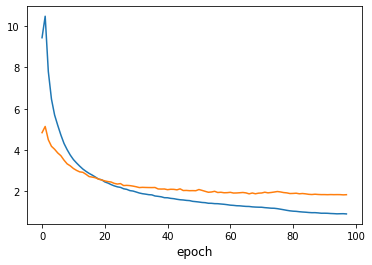

In [13]:
plt.figure()
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.xlabel("epoch", fontsize="large")
plt.show()
plt.close()

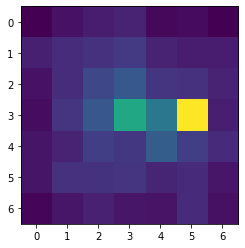

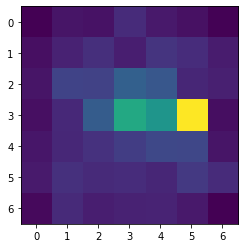

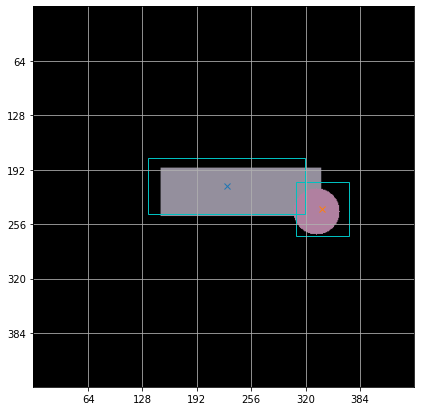

In [29]:
# Plot an example

# Must be less than batch size
IMG_NUM = 5

# We will just shuffle the test set and take a batch sample.  Then we plot some 
# heat maps of the predicted IOUs and plot the best bounding boxes.
for s_samp in X_test.shuffle(256).take(1):
  y_pred=yolo_model.predict(s_samp[0])
  y = tf.exp(y_pred[IMG_NUM, :, :, :]).numpy()

  plt.imshow(y[:,:,4].T)
  plt.figure()
  plt.imshow(y[:,:,9].T)

  y_ind = np.logical_or(y[:,:,4] < 0.3, np.logical_and(y[:,:,10] < 0.5, y[:,:,11] < 0.5))

  y[y_ind, :] = np.zeros((np.sum(y_ind), 13))  

  X_data.plotImg(s_samp[0][IMG_NUM, :, :, :], np.concatenate((y[:, :, :4], y[:, :, B*5:]), -1))